# Training Trajectory Corrector

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from glob import glob
# from flow_predictor import flow_predictor
from tqdm import tqdm
# from pathgen import training_twosteps

mps_device = torch.device("cuda:1")

plt.close('all')
from constants.filepath import PROJECT_PATH
import os

In [2]:
residuals = np.load(os.path.join(PROJECT_PATH, 'model_data', 'training_residuals.npz'))['residuals']
command_data = np.load(os.path.join(PROJECT_PATH, 'model_data', 'training_command_data.npz'))['command_data']
analytical_data = np.load(os.path.join(PROJECT_PATH, 'model_data', 'training_analytical_data.npz'))['analytical_data']

test_residuals = np.load(os.path.join(PROJECT_PATH, 'model_data', 'test_residuals.npz'))['residuals']
test_command = np.load(os.path.join(PROJECT_PATH, 'model_data', 'test_command_data.npz'))['command_data']
test_analytical = np.load(os.path.join(PROJECT_PATH, 'model_data', 'test_analytical_data.npz'))['analytical_data']


input_data = np.stack((command_data, analytical_data), axis=1)
# input_features = torch.tensor(analytical_data, dtype=torch.float32, device=mps_device).view(-1, 1)
input_features = torch.tensor(input_data, dtype=torch.float32, device='cpu')
target_residuals = torch.tensor(residuals, dtype=torch.float32, device='cpu').view(-1, 1)

test_input_data = np.stack((test_command, test_analytical), axis=1)
test_input_features = torch.tensor(test_input_data, dtype=torch.float32, device='cpu')
test_target_residuals = torch.tensor(test_residuals, dtype=torch.float32, device='cpu').view(-1, 1)

print("input_features shape:", input_features.shape)
print("target_residuals shape:", target_residuals.shape)

input_features shape: torch.Size([2338665, 2])
target_residuals shape: torch.Size([2338665, 1])


In [3]:
class BigManBlastoiseDataset(torch.utils.data.Dataset):
    def __init__(self, input_features, target_residuals):
        self.data_length = input_features.shape[0]
        self.input_features = input_features
        self.target_residuals = target_residuals
    def __getitem__(self, idx):
        return self.input_features[idx], self.target_residuals[idx]
    def __len__(self):
        return self.data_length

In [4]:
train_dataset= BigManBlastoiseDataset(input_features, target_residuals)
val_dataset = BigManBlastoiseDataset(test_input_features, test_target_residuals)
# random_split = torch.utils.data.random_split
# train_ratio = 0.9
# train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*train_ratio), len(dataset) - int(len(dataset)*train_ratio)])
# 524288
# 1048576
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=524288, shuffle=True, num_workers=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=524288, shuffle=True, num_workers=16)


data_batch, data_label = next(iter(train_dataloader))
print(data_batch.shape)
print(data_label.shape)
print(data_batch.device)

torch.Size([524288, 2])
torch.Size([524288, 1])
cpu


In [5]:
class ResidualModel(torch.nn.Module):
    def __init__(self, fc_dim_list = [2, 64, 512, 1024, 512, 64, 1]):
        super(ResidualModel, self).__init__()

        self.sequence = []
        for i in range(1,len(fc_dim_list)):
            self.sequence.append(torch.nn.Linear(fc_dim_list[i-1], fc_dim_list[i]))
            if i < len(fc_dim_list)-1:
                self.sequence.append(torch.nn.ReLU())
        self.sequence = torch.nn.Sequential(*self.sequence)

    def forward(self, x):
        return self.sequence(x)

In [ ]:
model = ResidualModel()
model.to('cuda:1')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 100
model.train()

# input_features = torch.tensor(input_features).to('cuda:1')
# residuals = torch.tensor(residuals).to('cuda:1')

print("Training model...")
train_epoch_losses = []
val_epoch_losses = []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_epoch_loss = 0
    validation_epoch_loss = 0
    train_batch_cnt = 0
    for batched_input_features, batched_residuals in train_dataloader:
        batched_input_features = batched_input_features.to('cuda:1')
        batched_residuals = batched_residuals.to('cuda:1')
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(batched_input_features)
        loss = criterion(predictions, batched_residuals)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_epoch_loss += loss
            train_batch_cnt += 1
            
    with torch.no_grad():
        val_batch_cnt = 0
        for batched_input_features,batched_residuals in val_dataloader:
            val_batch_cnt += 1
            batched_input_features = batched_input_features.to('cuda:1')
            batched_residuals = batched_residuals.to('cuda:1')
            val_predictions = model(batched_input_features)
            val_loss = criterion(val_predictions, batched_residuals)
            
            validation_epoch_loss += val_loss
            val_batch_cnt += 1
    
    train_epoch_losses.append(train_epoch_loss.to('cpu') / train_batch_cnt)
    val_epoch_losses.append(validation_epoch_loss.to('cpu') / val_batch_cnt)
    
    pbar.set_postfix({'iter': epoch, 'train_loss': train_epoch_loss, 'val_loss': validation_epoch_loss})
    
    
    # # print loss every 10 epochs
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Training model...


 98%|█████████▊| 98/100 [17:02<00:20, 10.47s/it, iter=97, train_loss=tensor(1.8949, device='cuda:1'), val_loss=tensor(0.6398, device='cuda:1')]

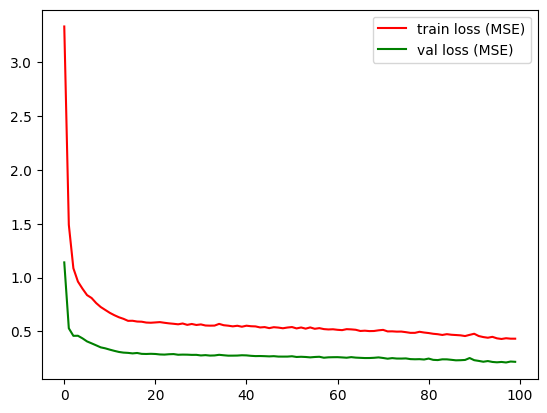

In [ ]:
train_epoch_losses = np.array(train_epoch_losses)
val_epoch_losses = np.array(val_epoch_losses)
plt.plot(np.arange(epochs), train_epoch_losses, c='r', label='train loss (MSE)')
plt.plot(np.arange(epochs), val_epoch_losses, c='g', label='val loss (MSE)')
plt.legend()

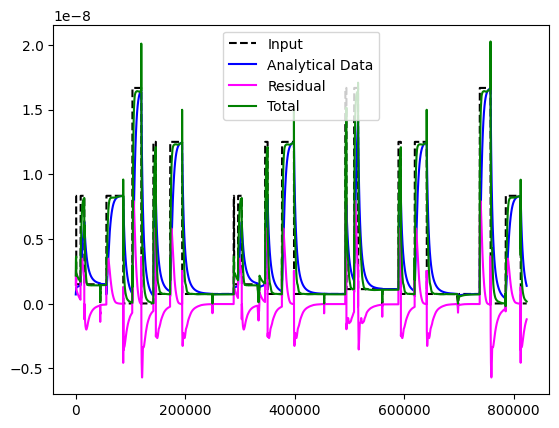

In [ ]:
# Example: Run model inference (optional, based on your needs)
model.eval()

#%%
test_command = np.load(os.path.join(PROJECT_PATH, 'model_data', 'test_command_data.npz'))['command_data']
test_analytical = np.load(os.path.join(PROJECT_PATH, 'model_data', 'test_analytical_data.npz'))['analytical_data']

test_combined = np.stack((test_command, test_analytical), axis=1)
test_input = torch.tensor(test_combined, dtype=torch.float32, device=mps_device)

with torch.no_grad():
    output = model(test_input) * 1e-9
    test_result = (output).cpu().numpy().reshape(-1)

test_t = np.arange(test_command.shape[0])   
plt.figure()
plt.plot(test_t, test_command / 1e9, label='Input', color='black', linestyle='--')
# plt.plot(test_accel.ts, test_accel.sim_Q_out, label = 'Simulated Data', color = 'red')
plt.plot(test_t, test_analytical / 1e9, label = 'Analytical Data', color = 'blue')
plt.plot(test_t, test_result, label='Residual', color='magenta')
plt.plot(test_t, (test_analytical / 1e9) + test_result, label='Total', color='green')
plt.legend()


In [ ]:
torch.save(model.state_dict(), 'trajectory_correction_DNN_v0_blastoise2 .pth')